In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [ ]:
# Load the dataset
df = pd.read_csv("/content/ZOMATO.NS (1).csv")


In [ ]:
# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = np.diff(data, axis=0)
    gain = (delta >= 0) * delta
    loss = (delta < 0) * -delta
    avg_gain = np.zeros_like(data)
    avg_loss = np.zeros_like(data)
    for i in range(1, len(data)):
        avg_gain[i] = (avg_gain[i-1] * (window - 1) + gain[i-1]) / window
        avg_loss[i] = (avg_loss[i-1] * (window - 1) + loss[i-1]) / window
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [ ]:
data = df['Close'].values.reshape(-1,1)

In [ ]:
# Calculate RSI
rsi = calculate_rsi(data)

# Add RSI as a new feature to the dataset
df['RSI'] = rsi

<ipython-input-3-e4a4653173f6>:11: RuntimeWarning: divide by zero encountered in divide
  rs = avg_gain / avg_loss
<ipython-input-3-e4a4653173f6>:11: RuntimeWarning: invalid value encountered in divide
  rs = avg_gain / avg_loss


In [ ]:
# Print the first few rows of the modified DataFrame
print(df.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2021-07-23  116.000000  138.899994  115.000000  126.000000  126.000000   
1  2021-07-26  126.349998  143.750000  125.300003  140.649994  140.649994   
2  2021-07-27  141.699997  147.800003  127.750000  132.899994  132.899994   
3  2021-07-28  131.000000  135.000000  123.550003  131.199997  131.199997   
4  2021-07-29  134.949997  144.000000  132.199997  141.550003  141.550003   

      Volume         RSI  
0  694895290         NaN  
1  249723854  100.000000  
2  240341900   63.706296  
3  159793731   58.675686  
4  117973089   72.772547  


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [ ]:
# Function to create the dataset with look back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [ ]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, look_back)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
543/543 - 3s - loss: 0.0173 - 3s/epoch - 5ms/step
Epoch 2/100
543/543 - 1s - loss: 6.0929e-04 - 1s/epoch - 2ms/step
Epoch 3/100
543/543 - 1s - loss: 4.7265e-04 - 966ms/epoch - 2ms/step
Epoch 4/100
543/543 - 1s - loss: 4.9437e-04 - 964ms/epoch - 2ms/step
Epoch 5/100
543/543 - 1s - loss: 4.8858e-04 - 970ms/epoch - 2ms/step
Epoch 6/100
543/543 - 1s - loss: 5.0543e-04 - 1s/epoch - 2ms/step
Epoch 7/100
543/543 - 1s - loss: 4.9119e-04 - 1s/epoch - 2ms/step
Epoch 8/100
543/543 - 1s - loss: 5.0751e-04 - 1s/epoch - 3ms/step
Epoch 9/100
543/543 - 1s - loss: 5.0251e-04 - 977ms/epoch - 2ms/step
Epoch 10/100
543/543 - 1s - loss: 4.8647e-04 - 994ms/epoch - 2ms/step
Epoch 11/100
543/543 - 1s - loss: 5.3387e-04 - 983ms/epoch - 2ms/step
Epoch 12/100
543/543 - 1s - loss: 4.8410e-04 - 973ms/epoch - 2ms/step
Epoch 13/100
543/543 - 1s - loss: 4.9447e-04 - 967ms/epoch - 2ms/step
Epoch 14/100
543/543 - 1s - loss: 4.9685e-04 - 966ms/epoch - 2ms/step
Epoch 15/100
543/543 - 1s - loss: 5.3001e-04 - 9

In [ ]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


5/5 [==============================] - 0s 3ms/step


In [ ]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# Calculate  mean absolute error
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score MAE: %.2f' % (trainScore_mae))
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score MAE: %.2f' % (testScore_mae))

Train Score MAE: 2.37
Test Score MAE: 2.73


In [ ]:
trainScore_mse = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score MSE: %.2f' % (trainScore_mse))
testScore_mse = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score MSE: %.2f' % (testScore_mse))

Train Score MSE: 11.29
Test Score MSE: 11.78


In [ ]:
# Interpolate the data to obtain the actual predicted value for the next day
def interpolate_data(actual_data, predicted_data):
    # Interpolate the missing values in the predicted data
    interpolated_data = np.interp(np.arange(len(actual_data)), np.arange(len(predicted_data)), predicted_data)
    return interpolated_data

In [ ]:
# Interpolate the training and testing predictions
interpolated_trainPredict = interpolate_data(scaler.inverse_transform(train_data), trainPredict.flatten())
interpolated_testPredict = interpolate_data(scaler.inverse_transform(test_data), testPredict.flatten())

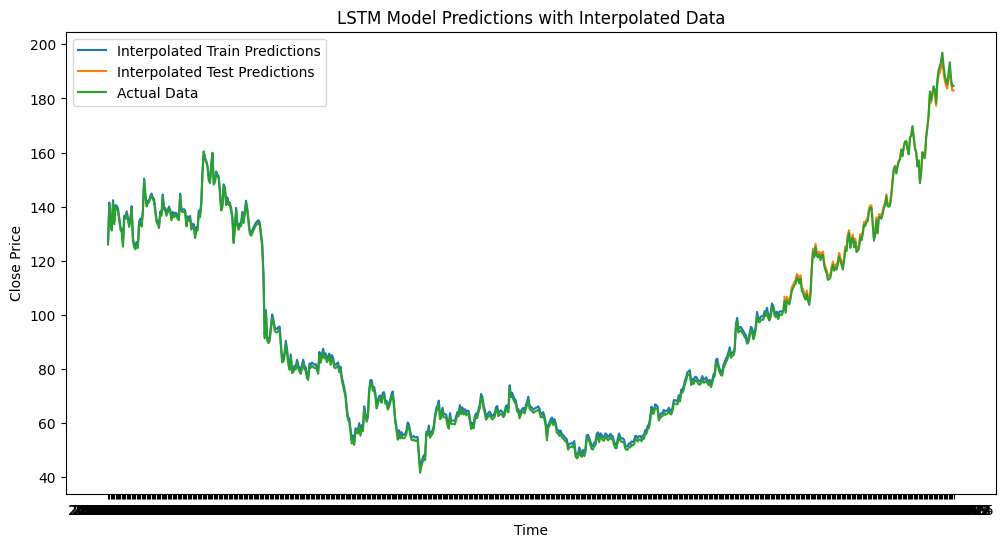

In [ ]:
# Plot the results with interpolated predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[:len(interpolated_trainPredict)], interpolated_trainPredict, label='Interpolated Train Predictions')
plt.plot(df['Date'].iloc[-len(interpolated_testPredict):], interpolated_testPredict, label='Interpolated Test Predictions')
plt.plot(df['Date'], df['Close'], label='Actual Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('LSTM Model Predictions with Interpolated Data')
plt.legend()
plt.show()



In [ ]:
# Plot the results
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(scaled_data), :] = testPredict




In [ ]:
# Get the last date in the dataset
last_date = df['Date'].iloc[-1]

# Convert the last date to datetime object and add one day to get the date of the next day
next_day_date = pd.to_datetime(last_date) + pd.Timedelta(days=1)

# Prepare the input data for prediction
last_data_point = scaled_data[-look_back:]
last_data_point = last_data_point.reshape((1, 1, look_back))

# Use the trained LSTM model to predict the value for the next day
next_day_prediction = model.predict(last_data_point)

# Inverse transform the predicted value to obtain the actual predicted price
next_day_predicted_price = scaler.inverse_transform(next_day_prediction)

print("Date of the next day:", next_day_date)
print("Predicted price for the next day:", next_day_predicted_price[0][0])


1/1 [==============================] - 0s 22ms/step
Date of the next day: 2024-04-26 00:00:00
Predicted price for the next day: 183.22566


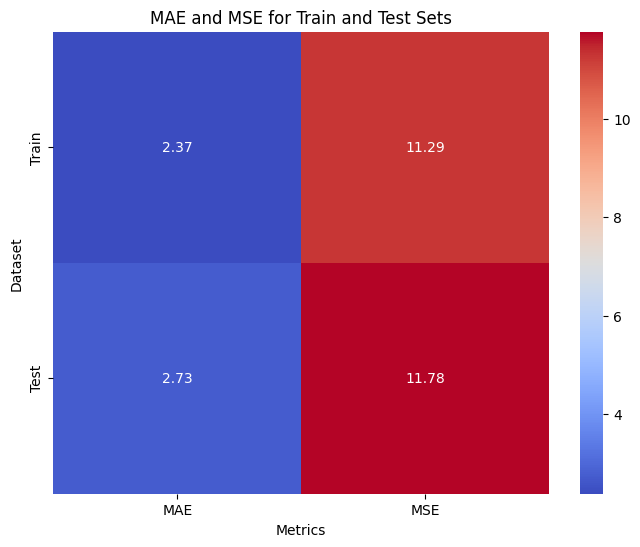

In [ ]:
import seaborn as sns

# Define MAE and MSE values
mae_values = [trainScore_mae, testScore_mae]
mse_values = [trainScore_mse, testScore_mse]
labels = ['Train', 'Test']

# Create a DataFrame for visualization
results_df = pd.DataFrame({'MAE': mae_values, 'MSE': mse_values}, index=labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(results_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('MAE and MSE for Train and Test Sets')
plt.xlabel('Metrics')
plt.ylabel('Dataset')
plt.show()
